### Population density in the Netherlands
- https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/gegevens-per-postcode

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [2]:
# Load the data/cbs_pc4_2022_v1_2.gpkg
data = gpd.read_file('data/cbs_pc4_2022_v1_2.gpkg')

# Replace -99997 with NaN
data = data.replace(-99997, 0)
data.head()

,postcode,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,...,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry
0,1011,9760,5105,4655,710,1180,3375,2580,1915,50,...,6055,30,70,2450,675,509,715,7084,1,"MULTIPOLYGON (((121972.810 486565.256, 121967...."
1,1012,8800,4840,3965,370,1690,4250,1725,770,40,...,5695,20,80,715,1070,480,610,8578,1,"MULTIPOLYGON (((121322.858 486672.120, 121254...."
2,1013,21940,10945,10995,2310,2415,7875,5940,3395,50,...,12400,30,70,6385,765,471,2525,6581,1,"MULTIPOLYGON (((121399.335 488004.302, 121384...."
3,1014,3660,1870,1790,785,185,1595,825,270,60,...,1565,50,50,160,180,731,175,3309,1,"MULTIPOLYGON (((120387.401 489859.870, 120375...."
4,1015,14910,7490,7420,1195,1760,5245,4150,2560,50,...,9475,30,70,3455,1150,532,1275,11080,1,"MULTIPOLYGON (((120228.336 487461.442, 120226...."


In [3]:
# Zuid-Holland postcodegebieden (22 to 32)
zuid_holland_pc2 = [n for n in range(22, 33)]

filter_zuid_holland = False
if filter_zuid_holland:
    data = data[data['postcode'].astype(str).str[:2].astype(int).isin(zuid_holland_pc2)]

In [4]:
# Calculate the area of each polygon in km2
data['area'] = data['geometry'].area / 10**6

# Calculate the population density
data['pop_density'] = data['aantal_inwoners'] / data['area']

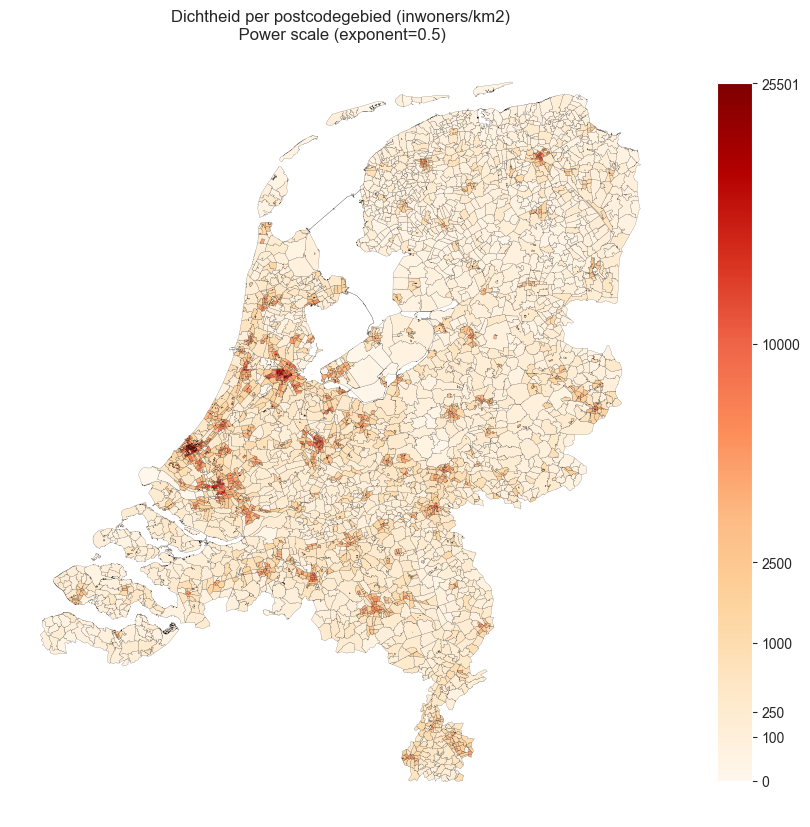

In [5]:
# Define a power transformation function
exponent = 0.5
def power_transform(data, exponent=exponent):
    return data ** exponent

# Apply the power transformation to pop_density
data['pop_density_transformed'] = power_transform(data['pop_density'])

# Define a custom normalization that takes the transformed data range
norm = Normalize(vmin=data['pop_density_transformed'].min(), vmax=data['pop_density_transformed'].max())

# Define your specific tick marks including the min and max of your data
specific_ticks = np.array([data['pop_density'].min(), 100, 250, 1000, 2500, 10000, data['pop_density'].max()])

# Apply the power transformation to these specific tick values for the colorbar
transformed_specific_ticks = power_transform(specific_ticks)

# Plot your data as before
fig, ax = plt.subplots(figsize=(15, 10))
data.plot(column='pop_density_transformed', legend=False, cmap='OrRd', edgecolor='black', linewidth=0.1, norm=norm, ax=ax)

# Remove the axis labels
plt.axis('off')

# Add a title
plt.title(f'Dichtheid per postcodegebied (inwoners/km2)\n Power scale (exponent={exponent})')

# Create a colorbar with the specified ticks
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='OrRd'), ax=ax, fraction=0.03, pad=0.04)

# Update the colorbar to use the transformed specific tick values
cbar.set_ticks(transformed_specific_ticks)

# Set the colorbar tick labels to the original specific tick values, adjusting the formatting as necessary
# Ensure labels are in integer format or adjust formatting as per your preference
cbar.set_ticklabels([f"{int(tick)}" for tick in specific_ticks])

plt.savefig('img/pop_density_pc4_transformed.png', dpi=300, bbox_inches='tight')

### Vehicles in the Netherlands
https://www.cbs.nl/nl-nl/maatwerk/2023/24/voertuigen-naar-brandstofsoort-en-postcode-2023

In [6]:
pd.set_option('future.no_silent_downcasting', True)

In [7]:
# Read data\brandstof-postcode-2023.xlsx, tab 'Tabel 1'
vehicles = pd.read_excel('data/brandstof-postcode-2023.xlsx', sheet_name='Tabel 1', skiprows=5, usecols='A:D')
# Drop Gemeentenaam and unnamed: 2
vehicles = vehicles.drop(columns=['Gemeentenaam', 'Unnamed: 2'])
# Drop the first row
vehicles = vehicles.drop(0)
# Replace '.' and missing with 0
vehicles = vehicles.replace('.', 0)
# Rename the columns
vehicles.columns = ['postcode', "personenautos"]
vehicles.head()

,postcode,personenautos
1,1000,0
2,1001,71
3,1005,0
4,1006,42
5,1007,0


In [8]:
# Merge the data and vehicles on 'postcode'
data = data.merge(vehicles, on='postcode', how='left')

In [9]:
# Fill missing values with 0 in personenautos
data['personenautos'] = data['personenautos'].fillna(0)

# Calculate the number of cars per inhabitant. Use 0 if the number of inhabitants is 0
data['personenautos_per_inwoner'] = data['personenautos'] / data['aantal_inwoners'].replace(0, 1)

# Cap on 1 car per inhabitant
data['personenautos_per_inwoner'] = data['personenautos_per_inwoner'].clip(upper=1).astype(float)
print(data['personenautos_per_inwoner'].dtype)

float64


In [10]:
# Remove postal codes with less than 100 inhabitants
data_clean = data[data['aantal_inwoners'] >= 10]

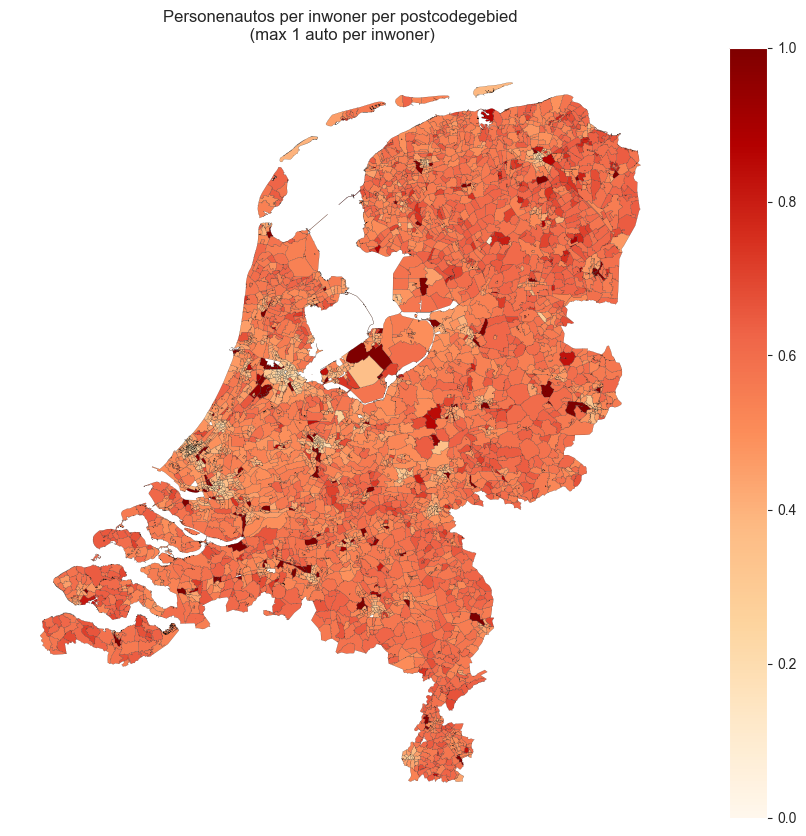

In [11]:
# Create a plot of the personenautos_per_inwoner
fig, ax = plt.subplots(figsize=(15,10))
data_clean.plot(column='personenautos_per_inwoner', legend=True, cmap='OrRd', edgecolor='black', linewidth=0.1, ax=ax)
# Remove the axis labels
plt.axis('off')
# Add a title
plt.title('Personenautos per inwoner per postcodegebied\n (max 1 auto per inwoner)')

# Save
plt.savefig('img/personenautos_per_inwoner_pc4.png', dpi=300, bbox_inches='tight')